In [1]:
from functions import save_complex32, load_complex32, stack_correlation
import os
import numpy as np
import pickle
import sys
import shutil
from pathlib import Path

sys.path.append("../common")

# This notebook provides the procedure used to filter and decrease the size of the original raw data.

**⚠️ Raw data files are not included in this repository due to Github's file size limitations, but they can accessed here: [doi.org/10.5281/zenodo.10058496](https://doi.org/10.5281/zenodo.10058496).**

Unzip the content of the files in folders with the same names as the zip file in the directory `Raw_data`

This step is only useful to regenerate the processed data from the raw data, it is not necessary for the computation and to generate the figures from the paper.


# Shrink data

**To limit the size of experimental data files in the repository, we extract here a subset of the whole data:**

- keep only few values of deformations
- take only one output polarization (algined with the input one)
- save imaginary and real part as float16 instead of using complex64 (imaginary and real as float32)
- use compression


In [2]:
FIBER = "Draka_GRIN"
# FIBER = "TL_GRIN3"
DEFORMATIONS_TO_SAVE = [0, 12, 18, 24, 28]
DATA_PATH = Path("../Raw_data") / FIBER
NEW_DATA_PATH = Path("../Data") / FIBER
FIBER_TYPE = "SI" if "SI" in FIBER else "GRIN"

os.makedirs(NEW_DATA_PATH, exist_ok=True)


def copy(file_name):
    shutil.copy2(DATA_PATH / file_name, NEW_DATA_PATH / file_name)

In [3]:
copy("param.pkl")
copy("modes.npz")

## A. Load parameters


In [4]:
with open(DATA_PATH / "param.pkl", "rb") as file:
    param = pickle.load(file, encoding="latin1")

In [5]:
param["fiber"]

{'NA': 0.2,
 'radius': 25,
 'name': 'GIF50C',
 'type': 'GRIN',
 'wl': 1.55,
 'n1': 1.46,
 'curvature': None,
 'length': 2500000.0,
 'ipitch': 2.232,
 'opitch': 1.2480000000000002,
 'inpoints': 30,
 'onpoints': 49}

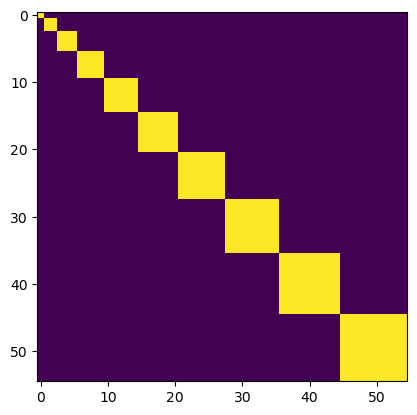

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(param["modes"]["deg_mask"])

In [7]:
# index value at which the tip enters in contact with the fiber
contact_ind = param["Deformation"]["contact_ind"]
press_indices = param["Deformation"]["press_indices"]  # [:n_TMs-1]
# number of pixels in each axis in the output plane (camera)
N_out = param["fiber"]["onpoints"]

# Deformation in microns
Delta_x = np.array(param["Deformation"]["steps_pressure"])[press_indices] * 1e3
Delta_x -= Delta_x[0]

In [8]:
# cut values of DEFORMATIONS_TO_SAVE that are not available
DEFORMATIONS_TO_SAVE = [
    i for i in DEFORMATIONS_TO_SAVE if i + contact_ind in press_indices
]

# Get the deformations
Delta_x_small = Delta_x[DEFORMATIONS_TO_SAVE]

In [9]:
TMs_mode = np.load(DATA_PATH / "TMs_mode.npy")
nmodes = TMs_mode.shape[-1]
TMs_mode = TMs_mode[:, :nmodes, :]
TMs_mode = TMs_mode[np.array(DEFORMATIONS_TO_SAVE) +
                    contact_ind].astype(np.complex64)

## B. Load data


In [10]:
# experimental data using random rotating masks
Ys_rnd = np.load(DATA_PATH / "Ys_rnd.npy").astype(np.complex64)

# experimental data using for the modes of the RME operators
# check if the file exists
is_rm = False
if (DATA_PATH / "Ys_rm.npy").exists():
    Ys_rm = np.load(DATA_PATH / "Ys_rm.npy").astype(np.complex64)
    is_rm = True


# experimental rotated focusing (amplitude only)
Ys_focus = np.abs(np.load(DATA_PATH / "Ys_focus.npy")).astype(np.float32)

## C. Reduce size


In [11]:
Ys_rnd_small = Ys_rnd[DEFORMATIONS_TO_SAVE, ..., :N_out, :]
Ys_rnd_small = Ys_rnd_small.reshape(
    list(Ys_rnd_small.shape[:-2]) + [N_out * N_out])
Ys_focus_small = Ys_focus[DEFORMATIONS_TO_SAVE, ..., :N_out, :]
if is_rm:
    Ys_rm_small = Ys_rm[DEFORMATIONS_TO_SAVE, ..., :N_out, :]
    Ys_rm_small = Ys_rm_small.reshape(
        list(Ys_rm_small.shape[:-2]) + [N_out * N_out])

In [12]:
Ys_focus_small = Ys_focus[DEFORMATIONS_TO_SAVE, ..., :N_out, :]

In [13]:
Ys_rnd_small_p2 = Ys_rnd[DEFORMATIONS_TO_SAVE, ..., N_out:, :]
Ys_rnd_small_p2 = Ys_rnd_small_p2.reshape(
    list(Ys_rnd_small_p2.shape[:-2]) + [N_out * N_out]
)

## D. Save new files


In [14]:
for i, ind in enumerate(DEFORMATIONS_TO_SAVE):
    save_complex32(
        NEW_DATA_PATH / f"Ys_rnd_small_p1_{ind}.npz",
        Ys_rnd_small[i],
    )

for i, ind in enumerate(DEFORMATIONS_TO_SAVE):
    save_complex32(
        NEW_DATA_PATH / f"Ys_rnd_small_p2_{ind}.npz",
        Ys_rnd_small_p2[i],
    )

if is_rm:
    save_complex32(
        NEW_DATA_PATH / "Ys_rm_small.npz",
        Ys_rm_small,
    )

np.save(NEW_DATA_PATH / "TMs_mode.npy", TMs_mode)

np.save(NEW_DATA_PATH / "Ys_focus_small.npy", Ys_focus_small)

## E. Store parameters associated with the shrinked data


In [15]:
pickle.dump(
    {
        "Delta_x": Delta_x_small,
        "deformation_indices": DEFORMATIONS_TO_SAVE,
        "n_deform": len(DEFORMATIONS_TO_SAVE),
        "fiber": FIBER,
        "fiber_type": FIBER_TYPE,
    },
    open(NEW_DATA_PATH / "param_small.pkl", "wb"),
)

## F. Compute RME correlation curve for all deformations


In [16]:
n_angles = Ys_rnd.shape[1]
n_ave = Ys_rnd.shape[2]
n_deform_tot = Ys_rnd.shape[0]

Ys_rnd[..., :N_out, :].shape

# flatten the two diemnsion axis
Ys = Ys_rnd[..., :N_out, :].reshape((n_deform_tot, n_angles, n_ave, -1))

# move the axis so that the penultimate one corresponds to angles
Ys = np.moveaxis(Ys, -3, -2)

# field correlation
Ys_ref = Ys[..., 0, :]
rnd_corr = stack_correlation(Ys, Ys_ref)


angles = np.linspace(0, 2 * np.pi, n_angles)
Corr_mean_exp = np.mean(np.abs(rnd_corr), axis=-2)
Corr_std_exp = np.std(np.abs(rnd_corr), axis=-2)

In [17]:
np.savez(
    open(NEW_DATA_PATH / "RME_corr.npy", "wb"),
    Delta_x=Delta_x,
    Corr_mean_exp=Corr_mean_exp,
    Corr_std_exp=Corr_std_exp,
    angles=angles,
    fiber=FIBER,
    fiber_type=FIBER_TYPE,
)